In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chic

from astropy import units as u
from astropy import constants as C
from scipy.integrate import solve_ivp

## Problem 1

## Part 5

The exact Klein-Gordon equation for the scalar field $\phi(N)$ is
$$
\phi_{,NN} + \left( \phi_{,N} + M_{\rm Pl}^2 \frac{V_{,\phi}}{V}  \right)
\left( 3  - \frac{\phi_{,N}^2}{2 M_{\rm Pl}^2} \right) = 0~, \quad
V(\phi) = M_{\rm Pl}^{4 - 2n} \frac{\lambda_n}{(2n)!} \phi^{2n}.
$$
Plugging in the potential and its derivative, we have
$$
0 = 
\phi_{,NN} + \left( \phi_{,N} + 2n \, M_{\rm Pl}^2 \, \phi^{-1} \right)
\left( 3  - \frac{\phi_{,N}^2}{2 M_{\rm Pl}^2} \right)~.
$$

We will want to compare against the slow-roll approximation, which has solution
$$
\phi^{\rm SR}(N) = \sqrt{\phi_i^2 - 4n \, M_{\rm Pl}^2 \, N}~, \quad 
\phi_i = \sqrt{2 \, M_{\rm Pl}^2 \, n \, (n + 120)}~,
$$
and derivative
$$
\phi^{\rm SR}_{,N} = - 2n \, M_{\rm Pl}^2 \, \phi(N)^{-1} \implies \phi_{,N}(0) = - 2n \, M_{\rm Pl}^2 / \phi_i
$$

We can set this up to be numerically integrated with a simple initial-value problem solver by splitting the single second-order ODE into two first-order ODEs.

Let $\phi \equiv \phi$, $\psi \equiv \phi_{,N}$. Then,
$$
\frac{d \phi}{dN} = \psi~, \quad
\frac{d \psi}{dN} = - \left( \psi + 2n \, M_{\rm Pl}^2 \, \phi^{-1} \right)
\left( 3  - \frac{\psi^2}{2 M_{\rm Pl}^2} \right)~.
$$

Lastly, we need to deal with units. It's always easiest if we can integrate dimensionless variables, so we define $\tilde{\phi} \equiv \phi/M_{\rm Pl}$ and $\tilde{\psi} \equiv \psi/M_{\rm Pl}$. Then the ODEs become
$$
\frac{d \tilde{\phi}}{dN} = \tilde{\psi}~, \quad
\frac{d \tilde{\psi}}{dN} = 
\left( \tilde{\psi} + 2n \, \tilde{\phi}^{-1} \right)
\left( \frac{1}{2} \tilde{\psi}^2 - 3 \right)~.
$$
and the initial conditions are
$$
\tilde{\phi}_i = \sqrt{2 \, n \, (n + 120)}, \quad \tilde{\psi}_i = - 2n / \tilde{\phi}_i.
$$

In [2]:
def df_dN(N, y, n=1):
    [phi, psi] = y
    dphi_dN = psi
    dpsi_dN = (psi + 2 * n / phi) * (0.5 * psi**2 - 3)
    return np.array([dphi_dN, dpsi_dN])

def solve(n, N_eval=None, psi_i_scale=1):
    phi_i = np.sqrt(2 * n * (n + 120))
    psi_i = (- 2 * n / phi_i) * psi_i_scale

    if N_eval is None:
        N_eval = np.arange(61)

    result = solve_ivp(df_dN, (0, 60), [phi_i, psi_i], method='BDF', t_eval=N_eval, args=(n,))
    if not result.status == 0:
        raise RuntimeError('Integration failed!\n' + result.message)

    phis = result.y[0]
    psis = result.y[1]
    return N_eval, result.y[0], result.y[1]

def slow_roll(n, N_eval):
    phi_i = np.sqrt(2 * n * (n + 120))
    return np.sqrt(phi_i**2 - 4 * n * Ns)

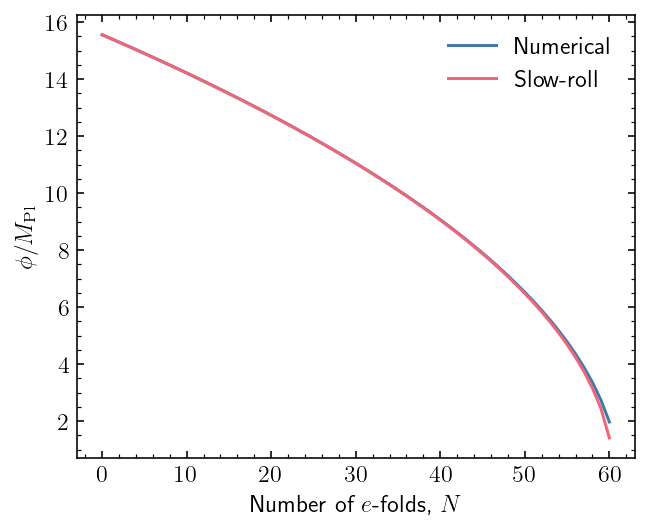

In [3]:
Ns, phis, psis = solve(1)
phis_SR = slow_roll(1, Ns)

plt.plot(Ns, phis)
plt.plot(Ns, phis_SR)
plt.xlabel(r'Number of $e$-folds, $N$')
plt.ylabel(r'$\phi / M_{\rm Pl}$')
plt.legend(['Numerical', 'Slow-roll'], frameon=False)
plt.show()

We are also asked to compute the evolution of the first slow-roll parameter $\epsilon$ and the potential slow-roll parameter $\epsilon_V$.

These are given by
$$
\epsilon \equiv - \frac{\dot{H}}{H^2} = \frac{1}{2} \frac{\phi_{,N}^2}{M_{\rm Pl}^2} = \frac{1}{2} \tilde{\psi}^2
$$
and
$$
\epsilon_V \equiv \frac{1}{2} M_{\rm Pl}^2 \left( \frac{V_{,\phi}}{V} \right)^2 = \frac{1}{2} M_{\rm Pl}^2 \, (2n)^2 \, \phi^{-2} = 2 n^2 \, \tilde{\phi}^{-2}
$$

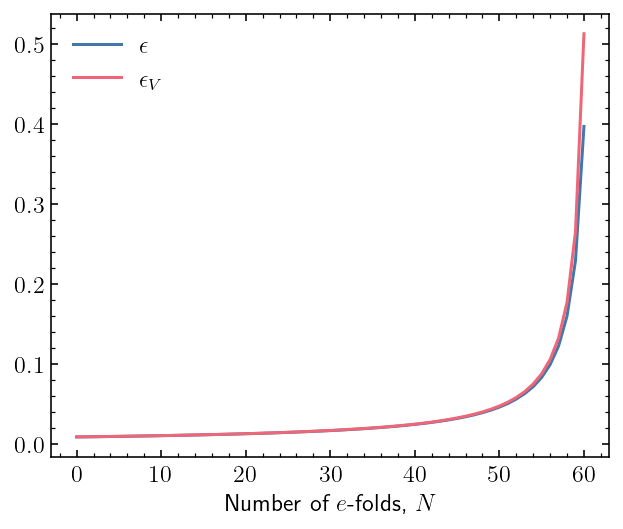

In [4]:
def first_SR(phi, psi, n=1):
    return 0.5 * psi**2

def first_pot_SR(phi, psi, n=1):
    return 2 * n**2 / phi**2

plt.plot(Ns, first_SR(phis, psis))
plt.plot(Ns, first_pot_SR(phis, psis))
plt.xlabel('Number of $e$-folds, $N$')
plt.legend(['$\\epsilon$', '$\\epsilon_V$'], frameon=False)
plt.show()

With accurate integration, neither of these hits $1$ at the end of 60 $e$-folds!

## Part 6

In [5]:
data = dict()

factors = [0, 1, 2, 5, 10]

for factor in factors:
    Ns, phis, psis = solve(1, psi_i_scale=factor)
    data[factor] = (Ns, phis, psis)

cmap = plt.get_cmap('tol_rainbow_PuRd')
norm = chic.mpl.colors.Normalize(vmin=0, vmax=len(factors)-1)

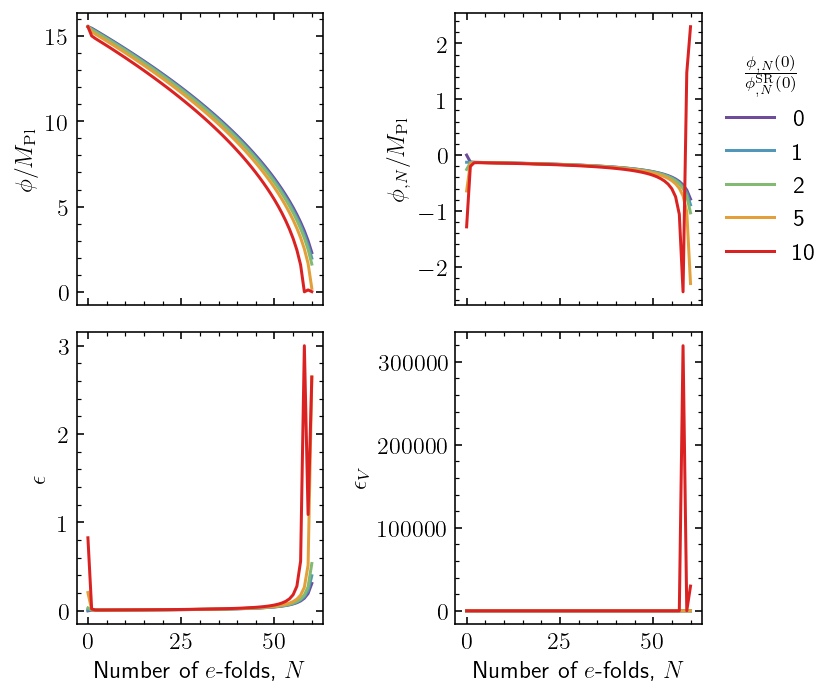

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(6, 5), sharex=True)

for i, factor in enumerate(factors):
    kw = dict(label=f"{factor}", color=cmap(norm(i)))

    Ns, phis, psis = data[factor]
    
    eps = first_SR(phis, psis)
    eps_V = first_pot_SR(phis, psis)
    
    axs[0, 0].plot( Ns, phis, **kw )
    axs[0, 1].plot( Ns, psis, **kw )
    axs[1, 0].plot( Ns, eps, **kw )
    axs[1, 1].plot( Ns, eps_V, **kw )

axs[-1, 0].set_xlabel(r'Number of $e$-folds, $N$')
axs[-1, 1].set_xlabel(r'Number of $e$-folds, $N$')

axs[0, 0].set_ylabel(r'$\phi / M_{\rm Pl}$')
axs[0, 1].set_ylabel(r'$\phi_{,N} / M_{\rm Pl}$')
axs[1, 0].set_ylabel(r'$\epsilon$')
axs[1, 1].set_ylabel(r'$\epsilon_V$')

axs[0, 1].legend(title=' $\\frac{\\phi_{,N}(0)}{\\phi^{\\rm SR}_{,N}(0)}$ ', frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))

fig.tight_layout()

plt.show()

Looks like it goes bad for large initial velocities when the slow-roll parameters exceed 1. Let's just stop it when this happens.

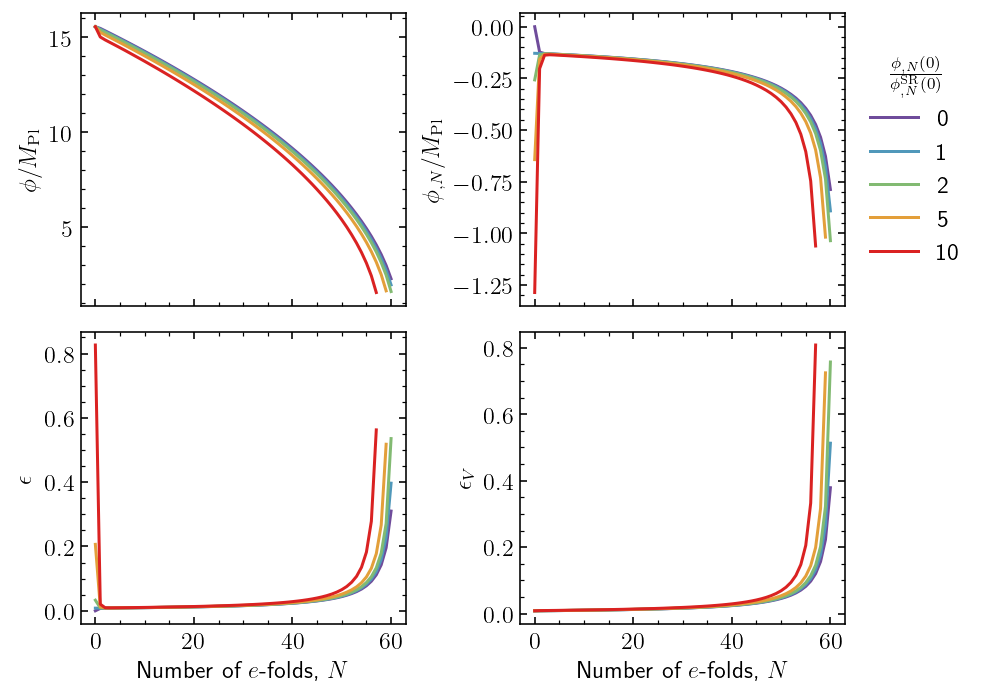

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex=True)

for i, factor in enumerate(factors):
    kw = dict(label=f"{factor}", color=cmap(norm(i)))

    Ns, phis, psis = data[factor]
    
    eps = first_SR(phis, psis)
    eps_V = first_pot_SR(phis, psis)

    mask = eps < 1
    
    axs[0, 0].plot( Ns[mask], phis[mask], **kw )
    axs[0, 1].plot( Ns[mask], psis[mask], **kw )
    axs[1, 0].plot( Ns[mask], eps[mask], **kw )
    axs[1, 1].plot( Ns[mask], eps_V[mask], **kw )

axs[-1, 0].set_xlabel(r'Number of $e$-folds, $N$')
axs[-1, 1].set_xlabel(r'Number of $e$-folds, $N$')

axs[0, 0].set_ylabel(r'$\phi / M_{\rm Pl}$')
axs[0, 1].set_ylabel(r'$\phi_{,N} / M_{\rm Pl}$')
axs[1, 0].set_ylabel(r'$\epsilon$')
axs[1, 1].set_ylabel(r'$\epsilon_V$')

axs[0, 1].legend(title='$\\frac{\\phi_{,N}(0)}{\\phi^{\\rm SR}_{,N}(0)}$', frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))

fig.tight_layout()

plt.show()

Much nicer! Now let's plot the phase-space trajectory of the field.

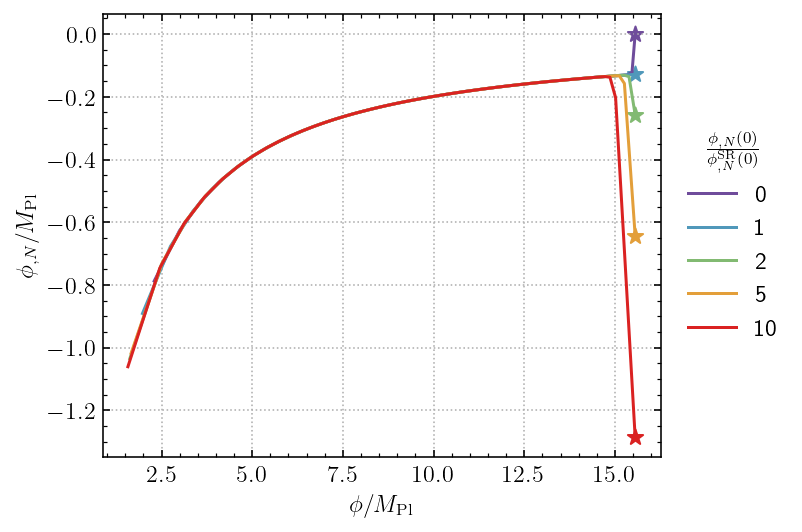

In [8]:
for i, factor in enumerate(factors):
    kw = dict(label=f"{factor}", color=cmap(norm(i)))

    Ns, phis, psis = data[factor]
    
    eps = first_SR(phis, psis)
    eps_V = first_pot_SR(phis, psis)

    mask = eps < 1
    plt.plot(phis[mask], psis[mask], **kw)
    plt.scatter(phis[0], psis[0], label='_skip', color=kw['color'], marker='*', s=64)

plt.legend(title='$\\frac{\\phi_{,N}(0)}{\\phi^{\\rm SR}_{,N}(0)}$', frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.xlabel('$\\phi / M_{\\rm Pl}$')
plt.ylabel('$\\phi_{,N} / M_{\\rm Pl}$')
plt.grid(ls=':')
plt.show()

It looks like the initial value of the derivative $\phi_{,N}$ has little effect on the trajectory, except that it speeds up or slows down the time at which inflation ends (defined as $\epsilon = 1$).